In [41]:
!pip install mysql-connector-python pandas

In [42]:
import mysql.connector
from mysql.connector import Error

try:
    connection = mysql.connector.connect(
        host='localhost',            
        database='incubator_tracker', 
        user='root',                 
        password='01042003',     
        auth_plugin='mysql_native_password'
    )

    if connection.is_connected():
        print("Connected to MySQL Server")

except Error as e:
    print("Error while connecting:", e)


Connected to MySQL Server


In [43]:
#1. SIMPLE QUERY 
#Query: List all events happening after 2024 in Back Bay Area 
import pandas as pd
cursor = connection.cursor()
query = '''
SELECT event_id, title, type, location, event_date 
FROM Event 
WHERE location LIKE '%Back Bay%' 
AND event_date >= '2024-01-01' 
ORDER BY event_date;
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_simple_events = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_simple_events)

   event_id                           title        type  location  event_date
0        33            Student Pitch Day 33       Pitch  Back Bay  2024-03-20
1        20  Student Investor Networking 20       Pitch  Back Bay  2024-04-02
2        48                  NU Bootcamp 48  Networking  Back Bay  2025-03-05
3        46  Harvard Investor Networking 46       Pitch  Back Bay  2025-11-19


In [44]:
#2. AGGREGATE   
#Query: Full Funding Statistics Per Startup
cursor = connection.cursor()
query = '''
SELECT  
    s.startup_id, 
    s.name AS startup_name, 
    SUM(fr.amount) AS total_funding, 
    COUNT(fr.funding_id) AS num_rounds, 
    AVG(fr.amount) AS avg_round_amount, 
    MIN(fr.amount) AS min_round_amount, 
    MAX(fr.amount) AS max_round_amount 
FROM Startup s 
LEFT JOIN FundingRound fr  
ON fr.startup_id = s.startup_id 
GROUP BY s.startup_id, s.name 
ORDER BY total_funding DESC;
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_funding_stats = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_funding_stats)
 


     startup_id    startup_name total_funding  num_rounds avg_round_amount  \
0            47    SparkWorks47    6163067.00           5   1232613.400000   
1            70      BetaApps70    4640394.00           2   2320197.000000   
2            73     AlphaLabs73    4567806.00           5    913561.200000   
3            93    EcoSystems93    4270085.00           3   1423361.666667   
4            74    AlphaWorks74    4080746.00           3   1360248.666667   
..          ...             ...           ...         ...              ...   
115          97    GreenWorks97          None           0             None   
116         101   FusionApps101          None           0             None   
117         112     BlueLabs112          None           0             None   
118         116   BrightTech116          None           0             None   
119         120  BlueDesigns120          None           0             None   

    min_round_amount max_round_amount  
0           22623.00   

In [45]:
# #3. INNER JOIN 
#Query: List mentors with their matched startups

cursor = connection.cursor()
query = '''
SELECT p.name AS mentor_name, s.name AS startup_name, sm.role 
FROM Mentor m 
JOIN People p ON p.person_id = m.person_id 
JOIN StartupMentor sm ON sm.mentor_id = m.mentor_id 
JOIN Startup s ON s.startup_id = sm.startup_id 
ORDER BY mentor_name;
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_mentors_startups = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_mentors_startups)


        mentor_name     startup_name              role
0    Abigail Carter        EcoLabs95           Advisor
1    Abigail Carter      NovaWorks91  Technical Mentor
2    Abigail Garcia      AlphaLabs33       Lead Mentor
3     Abigail Moore        BlueApps2       Lead Mentor
4     Abigail Moore  AlphaDesigns115           Advisor
..              ...              ...               ...
181    Yulia Taylor   NovaSystems106  Technical Mentor
182    Yulia Taylor       BetaLabs12  Technical Mentor
183    Yulia Taylor        EcoLabs81  Technical Mentor
184     Zoey Harris       NextLabs99  Technical Mentor
185     Zoey Harris    FusionWorks68           Advisor

[186 rows x 3 columns]


In [46]:
#4. NESTED QUERY (Subquery in WHERE clause) 
#Query: Entrepreneurs who founded more than one startup 

cursor = connection.cursor()
query = '''
SELECT e.entrepreneur_id, p.name 
FROM Entrepreneur e 
JOIN People p ON p.person_id = e.person_id 
WHERE e.entrepreneur_id IN ( 
    SELECT entrepreneur_id 
    FROM EntrepreneurStartup 
    GROUP BY entrepreneur_id 
    HAVING COUNT(startup_id) > 1
);
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_entrepreneurs_multiple = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_entrepreneurs_multiple)


    entrepreneur_id               name
0                 9        Nisha Davis
1                35       Grace Wilson
2                27        Skylar Hill
3                64     Chloe Robinson
4                30  Isabella Phillips
..              ...                ...
81               85      Divya Collins
82               47      Aurora Morris
83               12    Victoria Carter
84               67        Leah Thomas
85               54      Sara Robinson

[86 rows x 2 columns]


In [47]:
#5. SUBQUERY IN FROM (Derived Table) 
#Query: Average funding per industry (industry-level performance)

cursor = connection.cursor()
query = '''
SELECT industry, AVG(total_funding) AS avg_industry_funding 
FROM ( 
    SELECT s.industry, COALESCE(SUM(fr.amount),0) AS total_funding 
    FROM Startup s 
    LEFT JOIN FundingRound fr ON fr.startup_id = s.startup_id 
    GROUP BY s.startup_id, s.industry 
) AS industry_funding 
GROUP BY industry 
ORDER BY avg_industry_funding DESC;
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_avg_funding_industry = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_avg_funding_industry)


         industry avg_industry_funding
0       Education       1345490.214286
1          Health       1325390.500000
2  Sustainability        992505.800000
3         Fashion        922513.785714
4      E-commerce        854380.777778
5         Biotech        833825.285714
6            Food        575735.875000
7              AI        532545.000000
8            Tech        399638.450000
9         FinTech        194674.875000


In [48]:
#6. SUBQUERY IN SELECT  
#Query: How many startups each entrepreneur has founded 

cursor = connection.cursor()
query = '''
SELECT  
    p.name AS entrepreneur_name, 
    e.entrepreneur_id, 
    (SELECT COUNT(*) 
     FROM EntrepreneurStartup es 
     WHERE es.entrepreneur_id = e.entrepreneur_id 
    ) AS total_startups 
FROM Entrepreneur e 
JOIN People p ON p.person_id = e.person_id;
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_startups_per_entrepreneur = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_startups_per_entrepreneur)


    entrepreneur_name  entrepreneur_id  total_startups
0         Nisha Davis                9               2
1        Grace Wilson               35               3
2         Skylar Hill               27               3
3         Irene Reyes               59               0
4      Chloe Robinson               64               2
..                ...              ...             ...
105      Yulia Thomas               39               0
106     Aurora Morris               47               6
107   Victoria Carter               12               4
108       Leah Thomas               67               8
109     Sara Robinson               54               3

[110 rows x 3 columns]


In [49]:
#7. CORRELATED SUBQUERY 
#Query: Events with above-average participation compared to their own event type

cursor = connection.cursor()
query = '''
SELECT e.event_id, e.title, e.type, 
       (SELECT COUNT(*)  
        FROM EntrepreneurEvent ee 
        WHERE ee.event_id = e.event_id) AS attendees 
FROM Event e 
WHERE (SELECT COUNT(*) 
       FROM EntrepreneurEvent ee 
       WHERE ee.event_id = e.event_id) > 
      (SELECT AVG(x.attendee_count) 
       FROM ( 
         SELECT event_id, COUNT(*) AS attendee_count 
         FROM EntrepreneurEvent 
         GROUP BY event_id 
       ) x);
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_events_above_avg = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_events_above_avg)


    event_id                           title            type  attendees
0          6              Harvard Workshop 6        Demo Day          5
1          8              Boston Pitch Day 8      Networking         11
2          9             Student Pitch Day 9        Demo Day          5
3         19  Student Investor Networking 19           Pitch          6
4         20  Student Investor Networking 20           Pitch          6
5         23                NU Demo Night 23      Networking          6
6         26  Student Investor Networking 26        Workshop          7
7         27                MIT Pitch Day 27        Workshop          7
8         30                  NU Bootcamp 30  Investor Forum          6
9         31            Boston Demo Night 31           Pitch          6
10        32                 MIT Workshop 32        Workshop          6
11        33            Student Pitch Day 33           Pitch          5
12        36                NU Demo Night 36  Investor Forum    

In [50]:
#8. ALL 
#Query: Find startups whose total funding raised is greater than ALL investors’ minimum investment capacity.
cursor = connection.cursor()
query = '''
SELECT 
    s.startup_id,
    s.name AS startup_name,
    SUM(fr.amount) AS total_funding
FROM Startup s
JOIN FundingRound fr ON fr.startup_id = s.startup_id
GROUP BY s.startup_id, s.name
HAVING SUM(fr.amount) > ALL (
        SELECT capacity_min
        FROM Investor
      );
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_startups_gt_all = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_startups_gt_all)


    startup_id       startup_name total_funding
0           73        AlphaLabs73    4567806.00
1            7         GreenApps7     772242.00
2          100        BlueApps100    1154139.00
3           63  FusionSolutions63     729554.00
4           11         OmniTech11     108524.00
..         ...                ...           ...
68          12         BetaLabs12      80797.00
69          27     GreenDesigns27     361065.00
70         114   BlueSolutions114     407363.00
71         107       SparkLabs107      86506.00
72          10         NextApps10      54639.00

[73 rows x 3 columns]


In [51]:
#9. ANY 
#Query: Find investors whose minimum investment capacity is greater than the smallest funding amount of ANY startup.

cursor = connection.cursor()
query = '''
SELECT  
    i.investor_id, 
    p.name AS investor_name, 
    i.capacity_min 
FROM Investor i 
JOIN People p ON p.person_id = i.person_id 
WHERE i.capacity_min > ANY ( 
        SELECT amount 
        FROM FundingRound 
        WHERE amount IS NOT NULL 
      );
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_investors_gt_any = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_investors_gt_any)


    investor_id       investor_name capacity_min
0             4       Evelyn Parker     10000.00
1             5         Nora Martin     10000.00
2             6         Farah Young     10000.00
3             8       Violet Flores     10000.00
4             9         Claire Cruz     10000.00
5            10         Leena Perez     50000.00
6            11     Samantha Parker     25000.00
7            16           Isha Diaz     50000.00
8            17        Piper Harris     10000.00
9            18       Abigail Scott     50000.00
10           19      Paisley Martin     25000.00
11           20     Piper Hernandez     10000.00
12           21      Ella Rodriguez     50000.00
13           22          Riya Moore     25000.00
14           23       Nandini Young     50000.00
15           24      Abigail Carter     10000.00
16           25        Layla Wright     25000.00
17           29    Savannah Edwards     25000.00
18           31       Lily Robinson     10000.00
19           32     

In [52]:
#10. EXISTS + NOT EXISTS  
#Query: Find entrepreneurs who have founded at least one startup AND have never attended any event.

cursor = connection.cursor()
query = '''
SELECT  
    e.entrepreneur_id, 
    p.name AS entrepreneur_name 
FROM Entrepreneur e 
JOIN People p ON p.person_id = e.person_id 
WHERE EXISTS ( 
        SELECT 1 
        FROM EntrepreneurStartup es 
        WHERE es.entrepreneur_id = e.entrepreneur_id 
      ) 
  AND NOT EXISTS ( 
        SELECT 1 
        FROM EntrepreneurEvent ee 
        WHERE ee.entrepreneur_id = e.entrepreneur_id 
      );
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_entrepreneurs_no_event = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_entrepreneurs_no_event)


    entrepreneur_id  entrepreneur_name
0                35       Grace Wilson
1                27        Skylar Hill
2                30  Isabella Phillips
3                76    Savannah Wilson
4                93      Elena Johnson
5                18     Emilia Stewart
6                 6      Amelia Morris
7                51        Nora Rivera
8                61  Samantha Phillips
9                 7        Ava Stewart
10               60     Piper Phillips
11               77    Jasmine Johnson
12               36         Anna Perez
13               68        Leah Walker
14               82        Naomi Davis
15               83      Natalie Allen
16               29         Leah Lewis
17               87        Aubrey Diaz
18               26      Emilia Parker
19              104         Mia Martin
20               13    Claire Phillips
21               43   Madison Robinson
22              105      Josephine Lee
23              102       Alice Garcia
24               40      

In [53]:
#11. UNION 
#Query: All people who attended events as entrepreneurs or mentors 

cursor = connection.cursor()
query = '''
SELECT ep.event_id, ep.entrepreneur_id AS participant_id, 'Entrepreneur' AS role 
FROM EntrepreneurEvent ep 
UNION 
SELECT mp.event_id, mp.mentor_id AS participant_id, 'Mentor' AS role 
FROM MentorEvent mp;
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_all_participants = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_all_participants)


     event_id  participant_id          role
0           1               3  Entrepreneur
1           1               5  Entrepreneur
2           1              63  Entrepreneur
3           2               3  Entrepreneur
4           2              12  Entrepreneur
..        ...             ...           ...
335        57              54        Mentor
336        59               7        Mentor
337        59              59        Mentor
338        60              26        Mentor
339        60              50        Mentor

[340 rows x 3 columns]


In [54]:
#12. LEFT OUTER JOIN 
#Query: Show all startups and any funding rounds they have (including startups with no funding) 

cursor = connection.cursor()
query = '''
SELECT 
    s.startup_id, 
    s.name AS startup_name, 
    fr.funding_id, 
    fr.amount 
FROM Startup s 
LEFT JOIN FundingRound fr 
ON s.startup_id = fr.startup_id 
ORDER BY s.startup_id;
'''
cursor.execute(query)
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_startups_left_join = pd.DataFrame(rows, columns=columns)
cursor.close()

print(df_startups_left_join)


     startup_id      startup_name  funding_id     amount
0             1    BlueSolutions1       141.0   46815.00
1             2         BlueApps2        75.0   29881.00
2             3    FusionDesigns3        88.0  177259.00
3             4       BrightApps4         NaN       None
4             5          EcoTech5         NaN       None
..          ...               ...         ...        ...
184         118  BetaSolutions118       125.0   21977.00
185         118  BetaSolutions118       142.0    8590.00
186         118  BetaSolutions118       149.0   29366.00
187         119     FusionApps119       115.0  370889.00
188         120    BlueDesigns120         NaN       None

[189 rows x 4 columns]


In [55]:
# Simple analytics based on retrieved data

# --- 1. Total number of events in Back Bay after 2024 ---
num_back_bay_events = df_simple_events.shape[0]
print(f"Number of events in Back Bay after 2024: {num_back_bay_events}")

# --- 2. Top 5 startups by total funding ---
top5_startups = df_funding_stats[['startup_name', 'total_funding']].head(5)
print("\nTop 5 Startups by Total Funding:")
print(top5_startups)

# --- 3. Average funding per startup ---
avg_funding_per_startup = df_funding_stats['total_funding'].mean()
print(f"\nAverage funding per startup: {avg_funding_per_startup:.2f}")

# --- 4. Mentors with highest number of startups mentored ---
mentorship_counts = df_mentors_startups.groupby('mentor_name').size().sort_values(ascending=False)
top_mentors = mentorship_counts.head(5)
print("\nTop 5 mentors by number of startups mentored:")
print(top_mentors)

# --- 5. Entrepreneurs who founded more than one startup ---
multi_startup_entrepreneurs = df_entrepreneurs_multiple.shape[0]
print(f"\nNumber of entrepreneurs who founded more than one startup: {multi_startup_entrepreneurs}")

# --- 6. Average funding per industry ---
avg_funding_industry = df_avg_funding_industry.sort_values('avg_industry_funding', ascending=False)
print("\nTop industries by average funding:")
print(avg_funding_industry.head(5))

# --- 7. Average startups per entrepreneur ---
avg_startups_per_entrepreneur = df_startups_per_entrepreneur['total_startups'].mean()
print(f"\nAverage number of startups per entrepreneur: {avg_startups_per_entrepreneur:.2f}")

# --- 8. Events with above-average participation ---
avg_attendees = df_events_above_avg['attendees'].mean()
print(f"\nAverage number of attendees for events above average: {avg_attendees:.2f}")

# --- 9. Startups whose total funding > all investors' minimum capacity ---
num_startups_gt_all = df_startups_gt_all.shape[0]
print(f"\nNumber of startups with funding greater than all investors' minimum capacity: {num_startups_gt_all}")

# --- 10. Investors whose minimum capacity > any startup funding ---
num_investors_gt_any = df_investors_gt_any.shape[0]
print(f"\nNumber of investors with minimum capacity greater than any startup funding: {num_investors_gt_any}")

# --- 11. Entrepreneurs with at least one startup but never attended an event ---
num_entrepreneurs_no_event = df_entrepreneurs_no_event.shape[0]
print(f"\nNumber of entrepreneurs with startups but no event attendance: {num_entrepreneurs_no_event}")

# --- 12. Total participants (entrepreneurs + mentors) across all events ---
total_participants = df_all_participants.shape[0]
print(f"\nTotal number of participants across all events: {total_participants}")


Number of events in Back Bay after 2024: 4

Top 5 Startups by Total Funding:
   startup_name total_funding
0  SparkWorks47    6163067.00
1    BetaApps70    4640394.00
2   AlphaLabs73    4567806.00
3  EcoSystems93    4270085.00
4  AlphaWorks74    4080746.00

Average funding per startup: 1048056.48

Top 5 mentors by number of startups mentored:
mentor_name
Josephine White    6
Everly Thomas      5
Abigail Scott      5
Stella Hill        5
Claire Cruz        4
dtype: int64

Number of entrepreneurs who founded more than one startup: 86

Top industries by average funding:
         industry avg_industry_funding
0       Education       1345490.214286
1          Health       1325390.500000
2  Sustainability        992505.800000
3         Fashion        922513.785714
4      E-commerce        854380.777778

Average number of startups per entrepreneur: 3.16

Average number of attendees for events above average: 5.81

Number of startups with funding greater than all investors' minimum capacity: 73

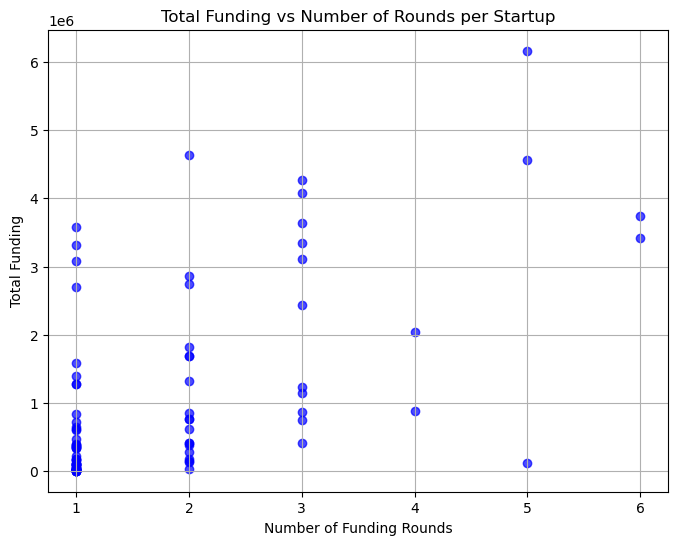

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Scatter Plot: Total Funding vs Number of Rounds per Startup ---
plt.figure(figsize=(8,6))
plt.scatter(df_funding_stats['num_rounds'], df_funding_stats['total_funding'], color='blue', alpha=0.7)
plt.title('Total Funding vs Number of Rounds per Startup')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Total Funding')
plt.grid(True)
plt.show()


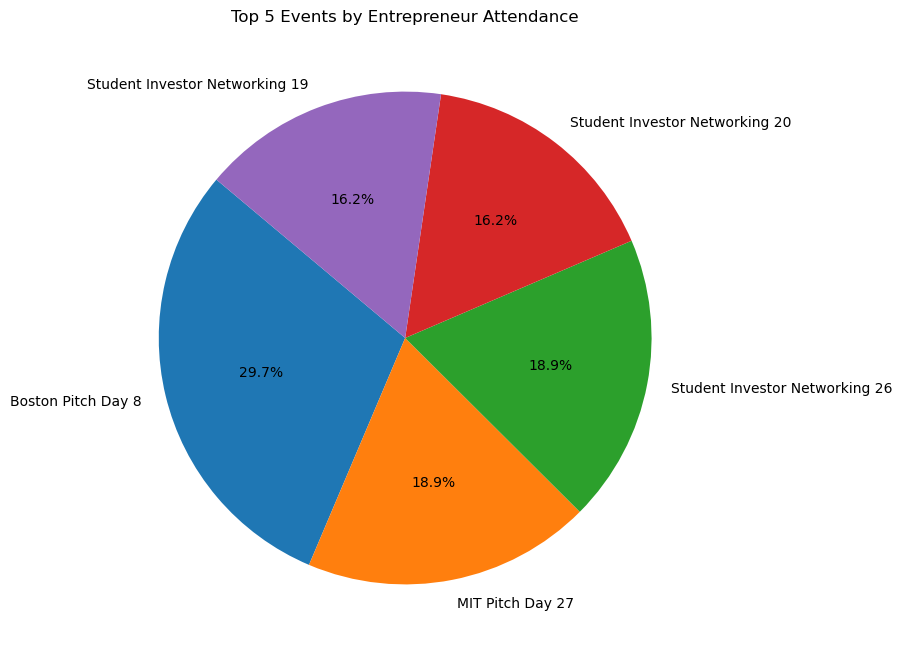

In [58]:
# --- 2. Pie Chart: Event Participation (Top 5 Events by Attendees) ---
top_events = df_events_above_avg.sort_values('attendees', ascending=False).head(5)

plt.figure(figsize=(8,8))
plt.pie(top_events['attendees'], labels=top_events['title'], autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Events by Entrepreneur Attendance')
plt.show()

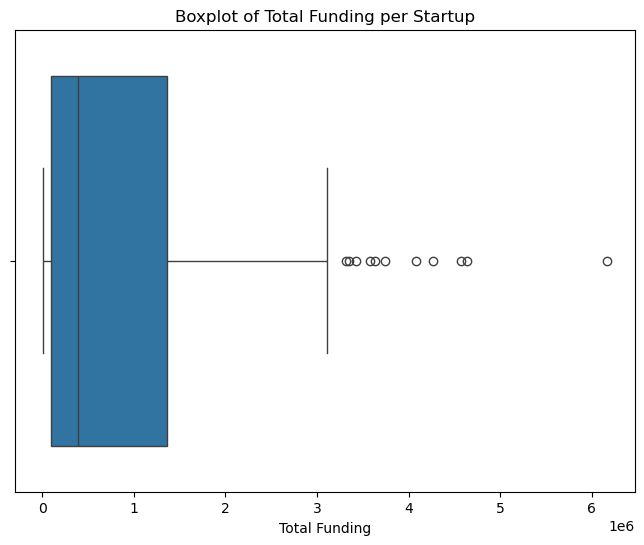

In [59]:
# --- 3. Boxplot: Total Funding per Startup ---
plt.figure(figsize=(8,6))
sns.boxplot(x=df_funding_stats['total_funding'])
plt.title('Boxplot of Total Funding per Startup')
plt.xlabel('Total Funding')
plt.show()

In [60]:
# Close cursor and connection
cursor.close()
connection.close()
print("Closed database connection.")


Closed database connection.
